In [1]:
import os
import glob
import lzma
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random 
import torch 
from sklearn.metrics import mean_squared_error
import math
import seaborn as sns

In [2]:
#change paths here if needed 
#model path 
model_path = 'pred_1726451985958.xz'
#subsample grouping path 
subsample_grouping = 'fund_subsample.csv'
#input data path 
input_path = 'char_withholdings_4rxfactor_v8_20240919_triproc_all.csv'

In [3]:
df = pd.read_csv(model_path)
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')
df = df.sort_values(by='Month', ascending=True).reset_index()
groupings = pd.read_csv('fund_subsample.csv')
group_n1 = groupings[groupings['group']==-1]['FundId'].to_list()
group_0 = groupings[groupings['group']==0]['FundId'].to_list()
group_1 = groupings[groupings['group']==1]['FundId'].to_list()
group_2 = groupings[groupings['group']==2]['FundId'].to_list()
group_3 = groupings[groupings['group']==3]['FundId'].to_list()
df_gn1 = df[df['FundId'].isin(group_n1)]
df_g0 = df[df['FundId'].isin(group_0)]
df_g1 = df[df['FundId'].isin(group_1)]
df_g2 = df[df['FundId'].isin(group_2)]
df_g3 = df[df['FundId'].isin(group_3)]
allinputs = pd.read_csv('char_withholdings_4rxfactor_v8_20240919_triproc_all.csv')
allinputs['aum'] = allinputs['aum'].apply(math.exp)

In [4]:
def check_chronological_order(df,timecol = 'Month'):
    df[timecol] = pd.to_datetime(df[timecol], format='%Y-%m-%d', errors='coerce')
    for i in range(1, len(df)):
        if df[timecol].iloc[i] < df[timecol].iloc[i - 1]:
            print(f"Chronological order breaks at row {i}, Month: {df[timecol].iloc[i]}")
            return False
    print(f"The {timecol} column is in chronological order.")
    return True
def plot_returns(df, method, cumulative=True, pred_weight = False, savedir= None, title = None):
    #df -> [timestep, decile, return_equal, return_pred]
    # for each decile, plot the return across all timesteps
    check_chronological_order(df, 'timestep')
    plt.figure(figsize=(10, 6))
    for i in range (10):
        df_decile = df[df['decile'] == i].copy()
        df_decile = df_decile.sort_values('timestep')
        if cumulative and method == 'sum': 
            df_decile['cumulative_return_equal'] = df_decile['return_equal'].cumsum()
            df_decile['cumulative_return_pred'] = df_decile['return_pred'].cumsum()
        elif cumulative and method == 'logsum':
            df_decile['cumulative_return_equal'] = np.exp(np.log1p(df_decile['return_equal']).cumsum()) - 1
            df_decile['cumulative_return_pred'] = np.exp(np.log1p(df_decile['return_pred']).cumsum()) - 1
        else:
            df_decile['cumulative_return_equal'] = df_decile['return_equal']
            df_decile['cumulative_return_pred'] = df_decile['return_pred']
        if pred_weight:
            plt.plot(df_decile['timestep'], df_decile['cumulative_return_pred'],  label=f'Decile {i}')
        else:
            plt.plot(df_decile['timestep'], df_decile['cumulative_return_equal'], label=f'Decile {i}')
    plt.xticks(rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Cumulative Abnormal Return' if cumulative else 'Return')
    if title: 
        plt.title(title)
    else: 
        plt.title('Cumulative Abnormal Returns Over Time' if cumulative else 'Abnormal Returns Over Time')
    plt.suptitle('Prediction-weighted' if pred_weight else 'Equally-weighted', fontsize=9, y=0.87)
    if savedir is not None:
        plt.savefig(savedir+"cumulative_abnormal_return.png", dpi=300, bbox_inches='tight')
    #plt.ylim(-1, 1)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
def decile_plot(df, pred_weight=True, title=None, plot=True):
    # decile plot 
    # just one model, df-> the model 
    df['rank'] = df.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
    df['decile'] = df.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
    check_chronological_order(df)
    df_monthly_return = calculate_month_return(df)
    df_monthly_return['timestep']=pd.to_datetime(df_monthly_return['timestep'])
    if plot: 
        plot_returns(df_monthly_return, method='sum', pred_weight=pred_weight, savedir=None, title=title)
    return df_monthly_return, df
def decile_plot_demeaned(df, df_mean, cluster=None, pred_weight=True, title=None):
    #demeaned version of plot
    #for every datapoint subtract mean 
    #cluster is the cluster of funds to select 
    cluster = df[df['FundId'].isin(cluster)]
    cluster['rank'] = cluster.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
    cluster['decile'] = cluster.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
    check_chronological_order(cluster)
    df_monthly_return = calculate_month_return(cluster)
    df_monthly_return['timestep']=pd.to_datetime(df_monthly_return['timestep'])
    check_chronological_order(df_monthly_return, 'timestep')
    df_mean['timestep']  = df_mean['Month']
    merged_df = pd.merge(df_monthly_return, df_mean[['timestep', 'future_ab_monthly_return']], on='timestep', how='left')
    merged_df['return_pred'] = merged_df['return_pred'] - merged_df['future_ab_monthly_return']
    merged_df['return_equal'] = merged_df['return_equal'] - merged_df['future_ab_monthly_return']
    plot_returns(merged_df, method='sum', cumulative=True, pred_weight=True, title=title)
    return merged_df

def calculate_month_return(df, predcol='future_ab_monthly_return_pred', decilecol='decile'):
    #df-> [FundId, month, decile, prediciton]
    #return df -> [timestep, decile, return_equal, return_pred]
    #return_equal -> equally weighted monthly return 
    #return_pred -> predicion weighted monthly return 
    results = []
    for timestep in df['Month'].unique():
        df_timestep = df[df['Month'] == timestep]
        for decile in df_timestep[decilecol].unique():
            df_decile = df_timestep[df_timestep[decilecol] == decile]
            return_equal = df_decile['future_ab_monthly_return'].mean() #equal weight
            #predition weight 
            month_returns = torch.tensor(df_decile['future_ab_monthly_return'].values, dtype=torch.float32)
            month_predictions = torch.tensor(df_decile[predcol].values, dtype=torch.float32)
            weights = month_predictions.clone()
            if decile >= 5:
                weights -= torch.min(month_predictions)
            elif decile < 5:
                weights -= torch.max(month_predictions)
            return_pred = torch.sum(month_returns * weights) / torch.sum(weights)
            #add to output 
            results.append({
                'timestep': timestep,
                'decile': decile,
                'return_equal': return_equal,
                'return_pred': return_pred.item()
            })
    result_df = pd.DataFrame(results)
    return result_df

def percentage_rows_with_ids(df, column, ids_list):
    count = df[column].isin(ids_list).sum()
    percentage = (count / len(df)) * 100
    return percentage
def percent_chart(percentages, groupnums, title, labels):
    plt.figure(figsize=(8, 6))
    plt.bar(groupnums, percentages)
    plt.xlabel('Group')
    plt.ylabel('Percentage')
    plt.title('Percentage by Category ' + title)
    plt.ylim(0, 100)  
    plt.xticks(ticks=range(len(groupnums)), labels=groupnums)
    plt.show()
def plot_cross_sectional_avg_cluster(clusters, title='', input = allinputs, weight=None, labels = ['GOV', 'ABS', 'CORP', 'MUNI']):
    #plot for all clusters 
    plt.figure(figsize=(10, 6))
    for i in range(len(clusters)):
        cluster = clusters[i]
        input_cluster = input[input['FundId'].isin(cluster)]
        if weight:
            def weighted_avg(input_cluster, weight=weight):
                weighted_ab_return = ((input_cluster['future_ab_monthly_return'] * input_cluster[weight].abs()).sum()) / (input_cluster[weight].abs().sum())
                return weighted_ab_return
            average_returns = input_cluster.groupby('Month').apply(weighted_avg).reset_index(name='weighted_ab_monthly_return')
            average_returns['Month'] = pd.to_datetime(average_returns['Month'])
            check_chronological_order(average_returns)
            average_returns['cumulative_ab_return']= average_returns['weighted_ab_monthly_return'].cumsum()
        else: 
            average_returns = input_cluster.groupby('Month')['future_ab_monthly_return'].median().reset_index()
            #average_returns['future_ab_monthly_return'] = average_returns['future_ab_monthly_return'] - average_returns['future_ab_monthly_return'].mean()
            average_returns['Month'] = pd.to_datetime(average_returns['Month'])
            check_chronological_order(average_returns)
            average_returns['cumulative_ab_return']= average_returns['future_ab_monthly_return'].cumsum()
        plt.plot(average_returns['Month'], average_returns['cumulative_ab_return'], linestyle='-', label=labels[i])
    ###add bench mark 
    if weight:
        average_returns = input.groupby('Month').apply(weighted_avg).reset_index(name='weighted_ab_monthly_return')
        average_returns['Month'] = pd.to_datetime(average_returns['Month'])
        check_chronological_order(average_returns)
        average_returns['cumulative_ab_return']= average_returns['weighted_ab_monthly_return'].cumsum()
        plt.plot(average_returns['Month'], average_returns['cumulative_ab_return'], linestyle='-', label=f'BenchMark')
    plt.xlabel('Year')
    plt.ylabel('Average Abnormal Return')
    plt.title('Cumulative abnormal returns for each category '+title)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Clusters")
    plt.show()
    return average_returns
def plot_histogram_kde(input_data, clusters, return_column='future_ab_monthly_return', labels = ['GOV', 'ABS', 'CORP', 'MUNI']):
    plt.figure(figsize=(12, 6))
    for i, cluster in enumerate(clusters):
        cluster_data = input_data[input_data['FundId'].isin(cluster)]  
        plt.figure(figsize=(14, 6))
        # Hist
        plt.subplot(1, 2, 1)
        plt.hist(cluster_data[return_column], bins=200, alpha=0.6, color=f'C{i}')
        plt.xlabel('Return')
        plt.ylabel('Frequency')
        plt.title(f'Cluster {labels[i]} - Histogram of Returns')
        plt.xlim(-0.05, 0.05)
        # KDE
        plt.subplot(1, 2, 2)
        sns.kdeplot(cluster_data[return_column], shade=True, color=f'C{i}')
        plt.xlabel('Return')
        plt.ylabel('Density')
        plt.title(f'Cluster {labels[i]} - KDE of Returns')
        plt.suptitle(f'Returns Distribution for Cluster {labels[i]}')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
        plt.xlim(-0.05, 0.05)
        plt.show()
def plot_decile_cluster_concentration(df, clusters, decile, labels = ['GOV', 'ABS', 'CORP', 'MUNI'], title='', plot=True):
    df = df[df['decile']==decile]
    timesteps = sorted(df['Month'].unique())
    concentration_df = pd.DataFrame({'timestep': timesteps})
    for i, cluster in enumerate(clusters):
        cluster_concentration = []
        for timestep in timesteps:
            timestep_df = df[df['Month'] == timestep]
            total_funds = timestep_df['FundId'].nunique()  # Total number of unique funds for this timestep
            # Calculate concentration for each cluster
            cluster_funds = timestep_df[timestep_df['FundId'].isin(cluster)]['FundId'].nunique()
            # Calculate concentration as the proportion of cluster funds to total funds
            concentration = cluster_funds / total_funds if total_funds > 0 else 0
            cluster_concentration.append(concentration*100)
        concentration_df[f'Cluster_{i}'] = cluster_concentration
    # Plotting the concentration over time
    if plot: 
        smoothed_concentration_df = concentration_df.set_index('timestep').rolling(window=6).mean().reset_index()
        plt.figure(figsize=(12, 6))
        for i in range(len(clusters)):
            plt.plot(smoothed_concentration_df['timestep'], smoothed_concentration_df[f'Cluster_{i}'], label=labels[i])
        plt.xlabel('Timestep')
        plt.ylabel('composition (%)')
        plt.title(title)
        plt.legend(title="Clusters")
        plt.grid(True)
        plt.show()
    return concentration_df
def plot_concentration_avg(df, clusters):
    percentage_avg_top_list = []
    percentage_avg_bot_list = []
    for i in range(len(clusters)): 
        concentration_df_top = plot_decile_cluster_concentration(df, clusters, decile=9, plot=False)
        percentage_avg_top = concentration_df_top[f'Cluster_{i}'].mean()
        concentration_df_bot = plot_decile_cluster_concentration(df, clusters, decile=0, plot=False)
        percentage_avg_bot = concentration_df_bot[f'Cluster_{i}'].mean()
        percentage_avg_top_list.append(percentage_avg_top)
        percentage_avg_bot_list.append(percentage_avg_bot)
    print(percentage_avg_bot_list, percentage_avg_top_list)
    x = np.arange(len(clusters))
    width = 0.35  
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, percentage_avg_top_list, width, label='Top Decile', color='skyblue')
    ax.bar(x + width/2, percentage_avg_bot_list, width, label='Bottom Decile', color='salmon')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Percentage Avg')
    ax.set_title('Percentage Avg Comparison for Each Cluster (Top vs. Bottom)')
    ax.set_xticks(x)
    ax.set_xticklabels(['GOV', 'ABS', 'Corp', 'Muni'])
    ax.legend()
def plot_any_cross_sectional_avg_cluster(cluster, title='', input = allinputs, plot=True):
    plt.figure(figsize=(10, 6))
    input_cluster = input[input['FundId'].isin(cluster)]
    average_returns = input_cluster.groupby('Month')['future_ab_monthly_return'].mean().reset_index()
    average_returns['Month'] = pd.to_datetime(average_returns['Month'])
    average_returns['cumulative_ab_return']= average_returns['future_ab_monthly_return'].cumsum()
    if plot:
        plt.plot(average_returns['Month'], average_returns['cumulative_ab_return'], linestyle='-')
        plt.xlabel('Year')
        plt.ylabel('Average Abnormal Return')
        plt.title('Average Abnormal Returns Over Time '+title)
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    return average_returns
def plot_decile_concentration_barchart(df, clusters, deciles = [0,9]):
    for decile_num in deciles:
        decile = df[df['decile']==decile_num]
        print(f'decile num: {decile_num}')
        percentages = []
        groupnums = []
        for i in range(len(clusters)): 
            subsample = clusters[i]
            percent  = percentage_rows_with_ids(decile, 'FundId', subsample)
            groupnums.append(i)
            percentages.append(percent)
            print(f'group{i} percentage {percent}')
        percent_chart(percentages, groupnums, f'decile {decile_num}', labels = ['GOV', 'ABS', 'CORP', 'MUNI'])

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rank'] = df.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decile'] = df.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykern

The Month column is in chronological order.
The timestep column is in chronological order.


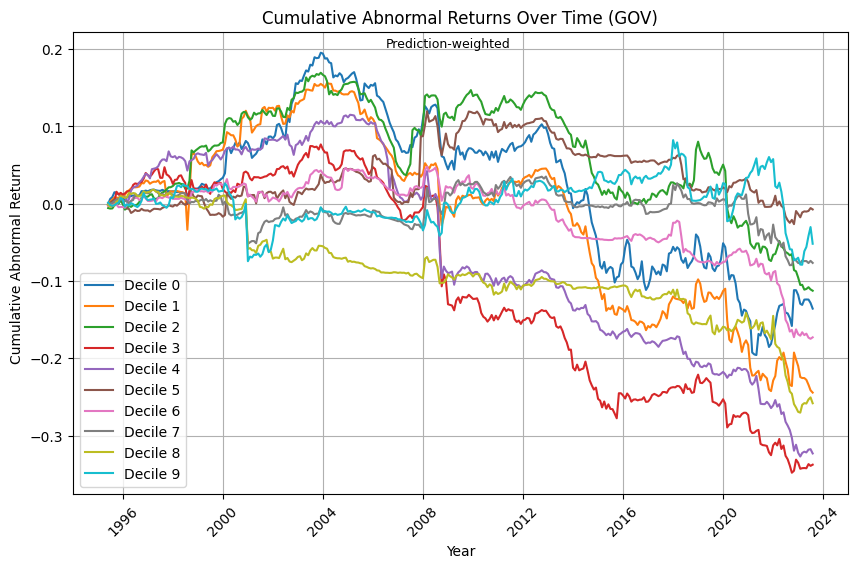

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rank'] = df.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decile'] = df.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykern

The Month column is in chronological order.
The timestep column is in chronological order.


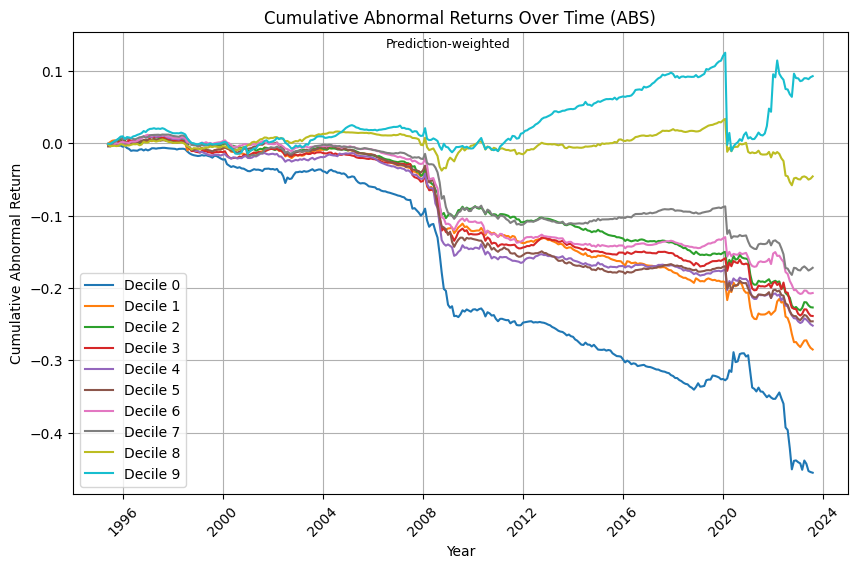

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rank'] = df.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decile'] = df.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykern

The Month column is in chronological order.
The timestep column is in chronological order.


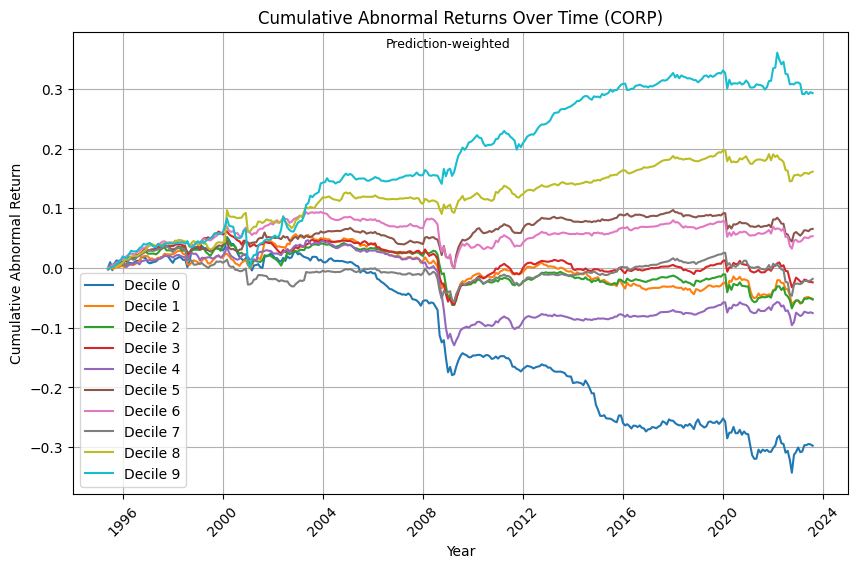

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rank'] = df.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['decile'] = df.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykern

The Month column is in chronological order.
The timestep column is in chronological order.


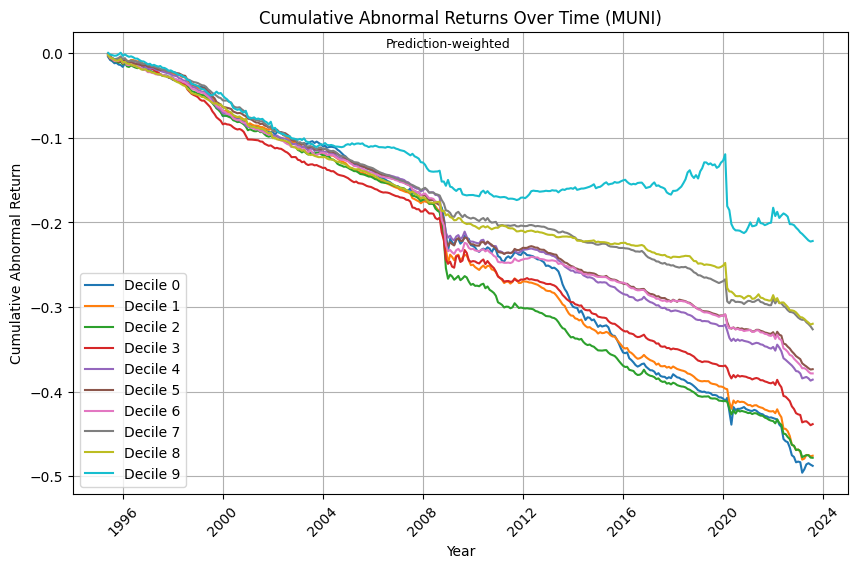

In [5]:
#1----### decile plot for each cluster 
clusters_df = [df_g0, df_g1, df_g2, df_g3]
labels = ['GOV', 'ABS', 'CORP', 'MUNI']
for i in range(len(clusters_df)):
    decile_plot(df=clusters_df[i], pred_weight=True, title=f'Cumulative Abnormal Returns Over Time ({labels[i]})')

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['rank'] = cluster.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['decile'] = cluster.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
/var/folders/by/qpw66qgj0ll1h0z_yglf

The Month column is in chronological order.
The timestep column is in chronological order.
The timestep column is in chronological order.


<Figure size 1000x600 with 0 Axes>

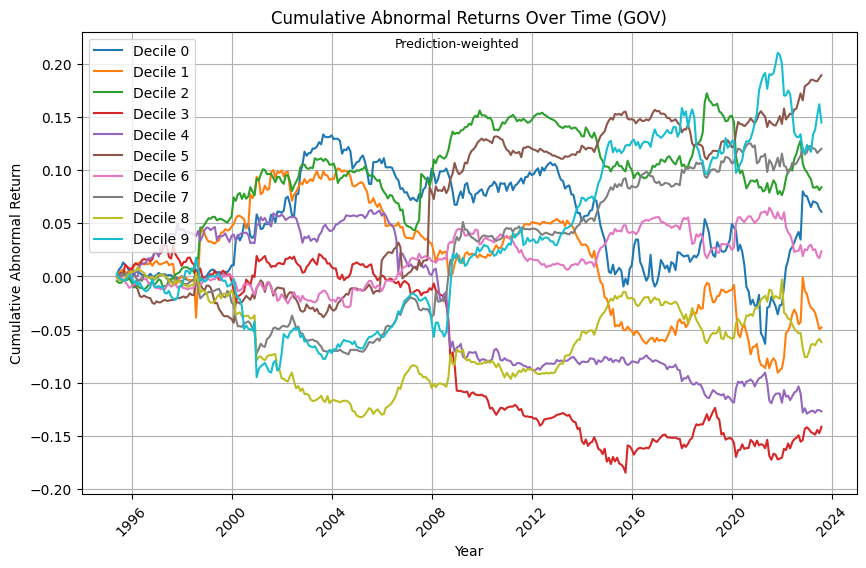

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['rank'] = cluster.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['decile'] = cluster.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
/var/folders/by/qpw66qgj0ll1h0z_yglf

The Month column is in chronological order.
The timestep column is in chronological order.
The timestep column is in chronological order.


<Figure size 1000x600 with 0 Axes>

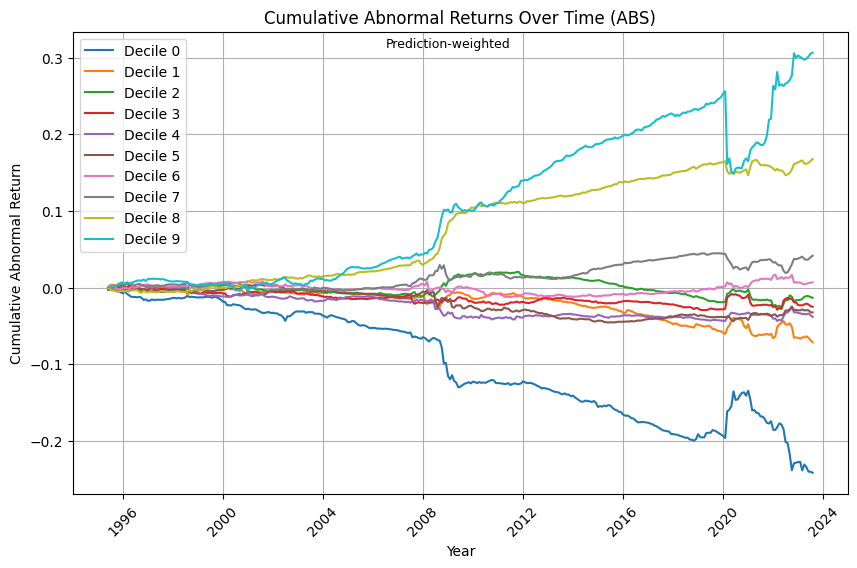

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['rank'] = cluster.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['decile'] = cluster.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
/var/folders/by/qpw66qgj0ll1h0z_yglf

The Month column is in chronological order.
The timestep column is in chronological order.
The timestep column is in chronological order.


<Figure size 1000x600 with 0 Axes>

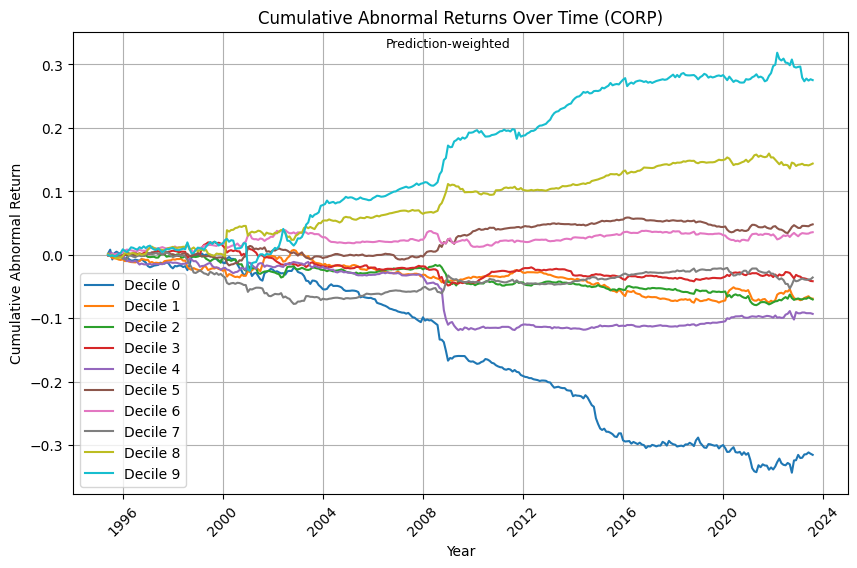

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['rank'] = cluster.groupby('Month')['future_ab_monthly_return_pred'].rank(method='first')
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster['decile'] = cluster.groupby(['Month'], group_keys=False)['rank'].transform(lambda x: pd.qcut(x, 10, labels=False))
/var/folders/by/qpw66qgj0ll1h0z_yglf

The Month column is in chronological order.
The timestep column is in chronological order.
The timestep column is in chronological order.


<Figure size 1000x600 with 0 Axes>

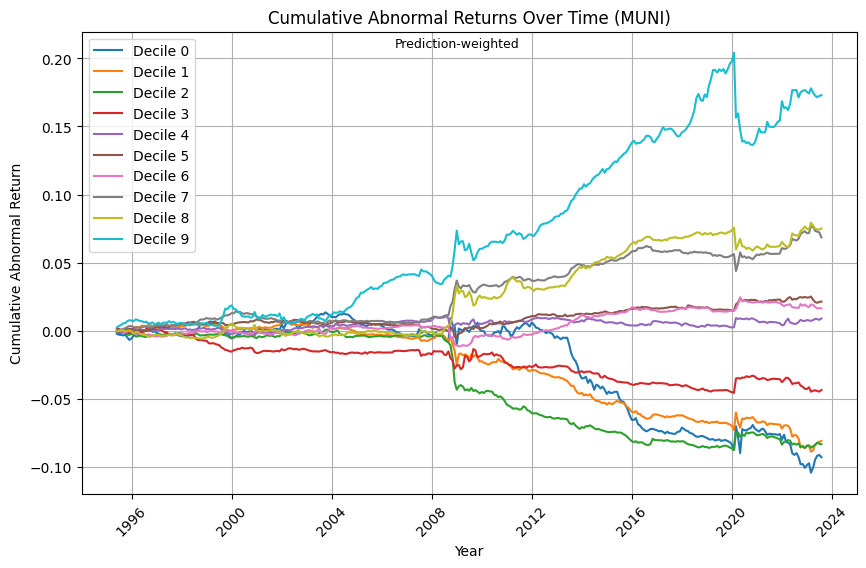

In [6]:
#2 --- ### decile plot for each cluster (take out mean)
clusters = [group_0, group_1,group_2,group_3]
labels = ['GOV', 'ABS', 'CORP', 'MUNI']
for i in range(len(clusters)):
    average_returns = plot_any_cross_sectional_avg_cluster(cluster=clusters[i], title=labels[i], plot=False)
    decile_plot_demeaned(df, average_returns, clusters[i], title=f'Cumulative Abnormal Returns Over Time ({labels[i]})')

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:166: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cluster_data[return_column], shade=True, color=f'C{i}')


<Figure size 1200x600 with 0 Axes>

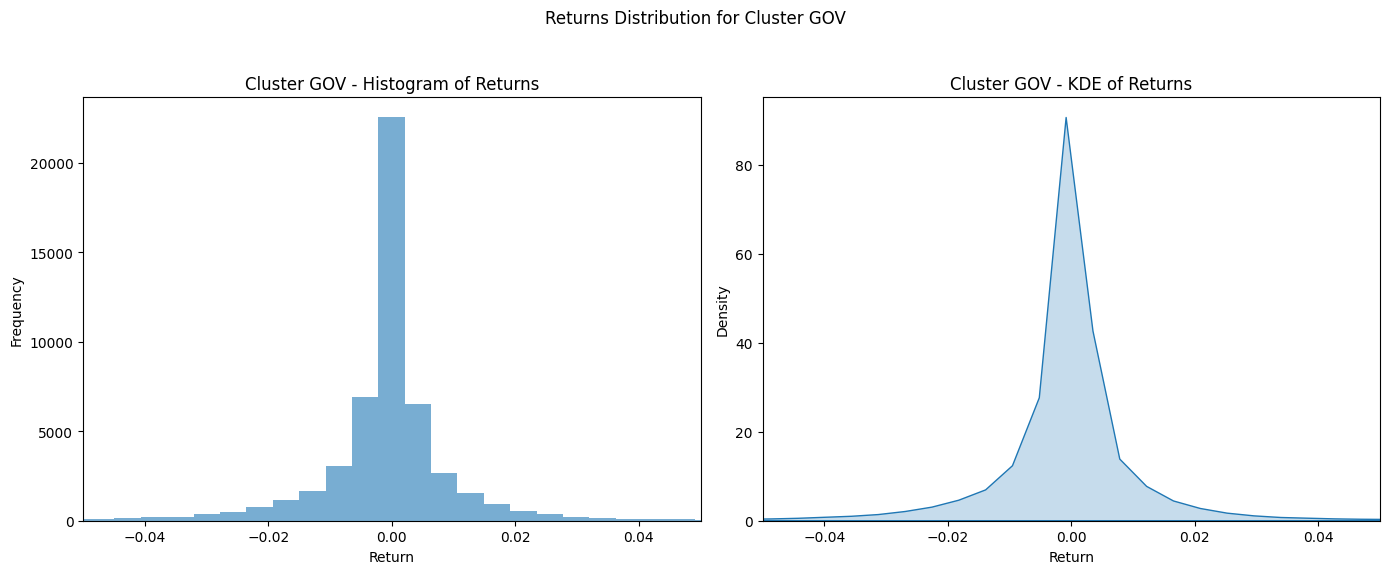

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:166: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cluster_data[return_column], shade=True, color=f'C{i}')


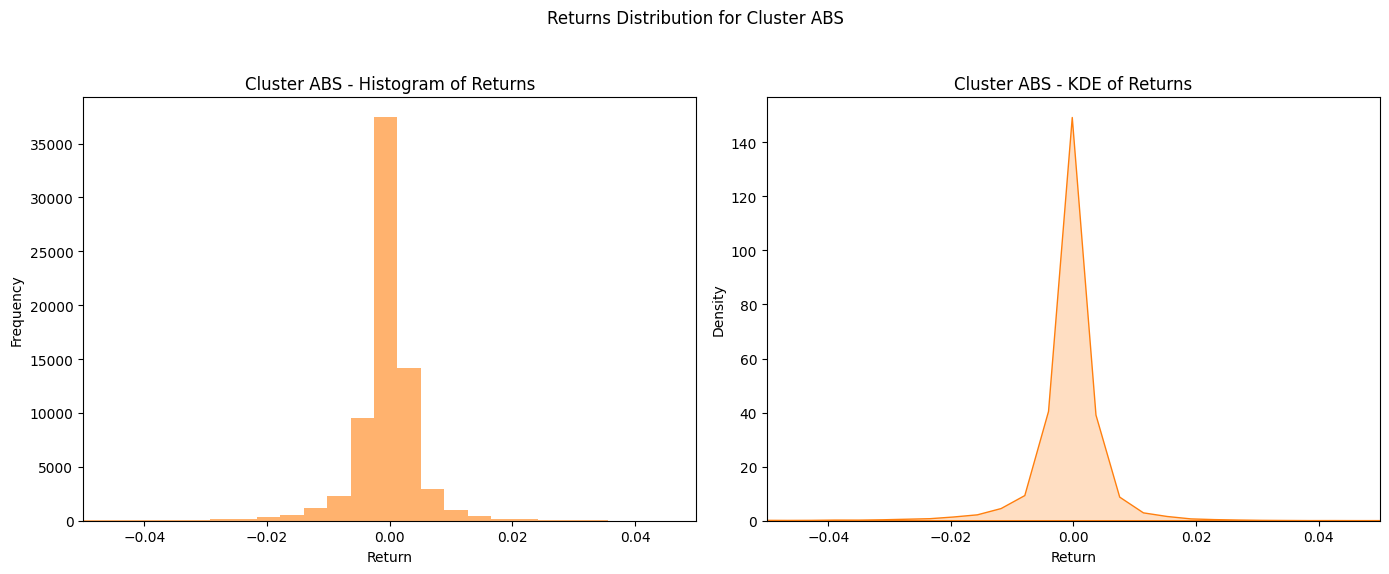

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:166: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cluster_data[return_column], shade=True, color=f'C{i}')


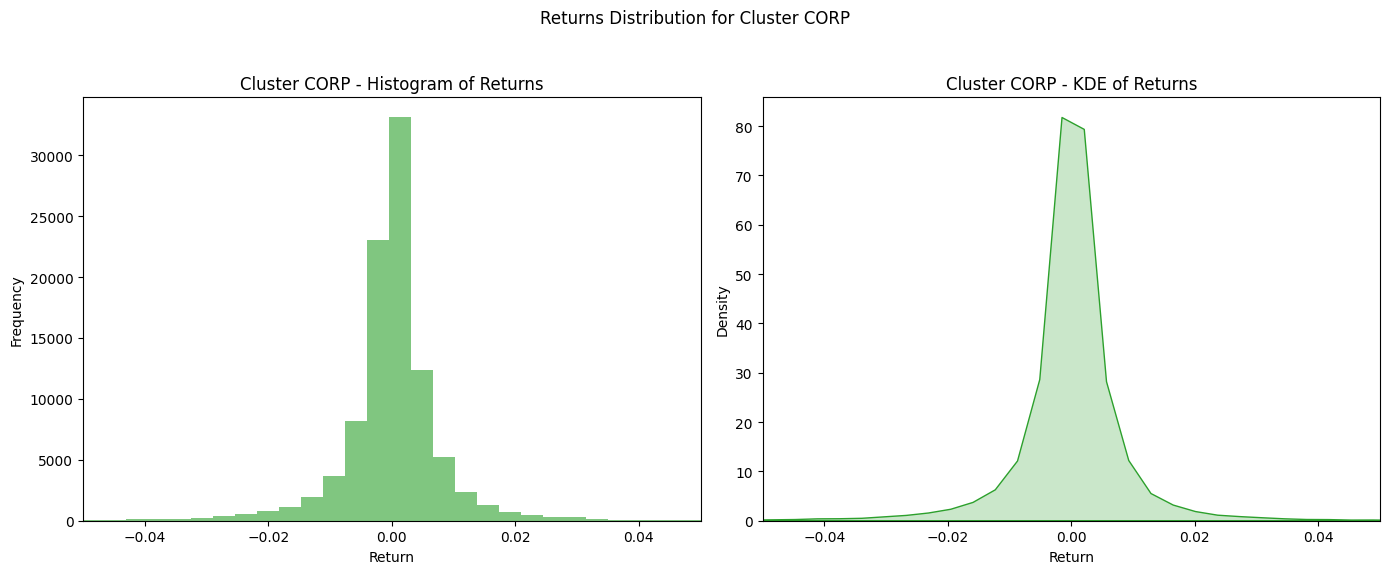

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:166: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cluster_data[return_column], shade=True, color=f'C{i}')


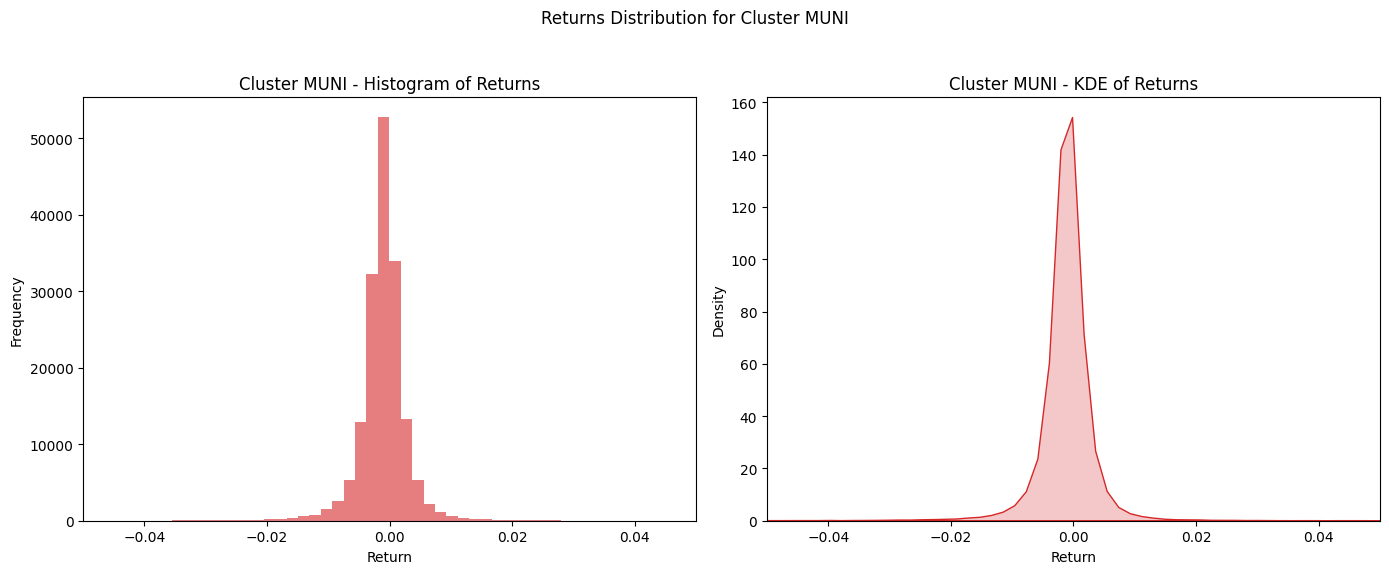

In [7]:
#3---- ##### distribution of returns for each cluster 
plot_histogram_kde(input_data=allinputs, clusters=[group_0, group_1, group_2, group_3])

/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:126: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_returns = input_cluster.groupby('Month').apply(weighted_avg).reset_index(name='weighted_ab_monthly_return')
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:126: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_returns = input_cluster.grou

The Month column is in chronological order.
The Month column is in chronological order.
The Month column is in chronological order.


/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:126: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_returns = input_cluster.groupby('Month').apply(weighted_avg).reset_index(name='weighted_ab_monthly_return')
/var/folders/by/qpw66qgj0ll1h0z_yglfwpfh0000gn/T/ipykernel_3245/3939958309.py:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  average_returns = input.groupby('Mon

The Month column is in chronological order.
The Month column is in chronological order.


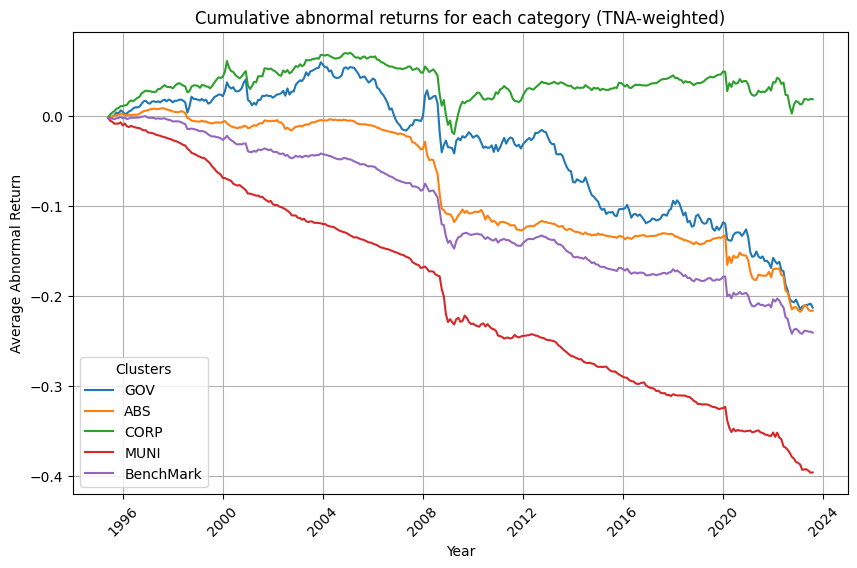

In [8]:
#4 --- ##### cross sectional cumulative avg returns for each cluster
average_returns = plot_cross_sectional_avg_cluster(clusters=[group_0, group_1, group_2, group_3], title='(TNA-weighted)', weight='aum')

The Month column is in chronological order.


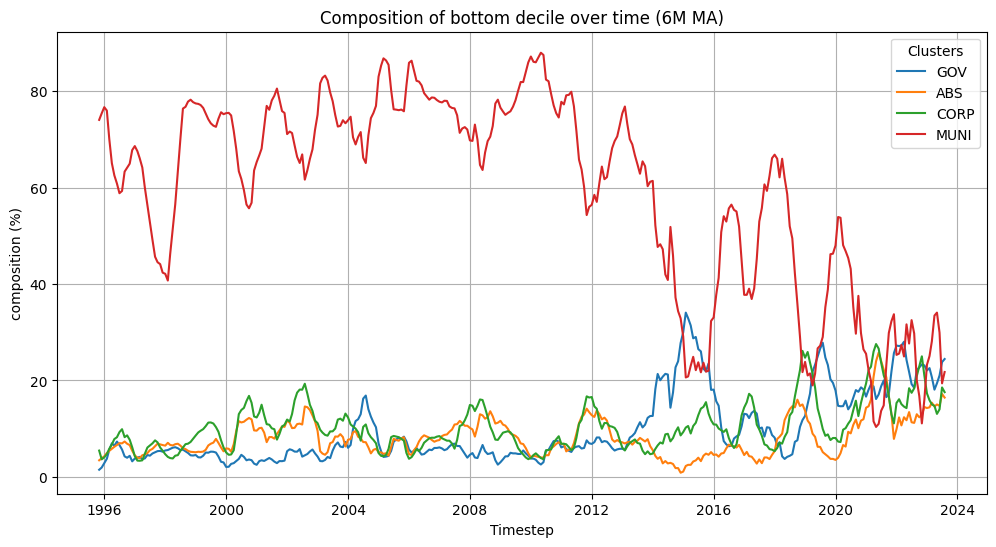

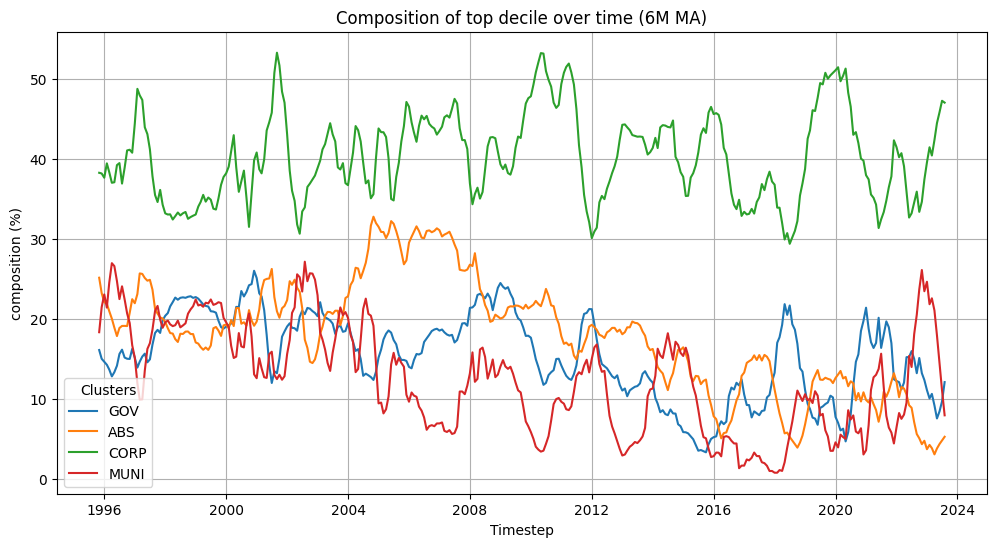

In [9]:
#5 ---- #### concentration lines for each cluster over cross sections 
df_monthly_return, df_out = decile_plot(df=df, pred_weight=True, plot=False)
concentration_df = plot_decile_cluster_concentration(df_out, clusters=[group_0,group_1,group_2,group_3], decile=0, title = 'Composition of bottom decile over time (6M MA)')
concentration_df = plot_decile_cluster_concentration(df_out, clusters=[group_0,group_1,group_2,group_3], decile=9, title = 'Composition of top decile over time (6M MA)')

The Month column is in chronological order.
[9.82735288908828, 8.238314598621407, 10.40303185120603, 59.117403964663644] [15.431147229894295, 18.005755343415586, 40.293476161257125, 12.479011109204771]


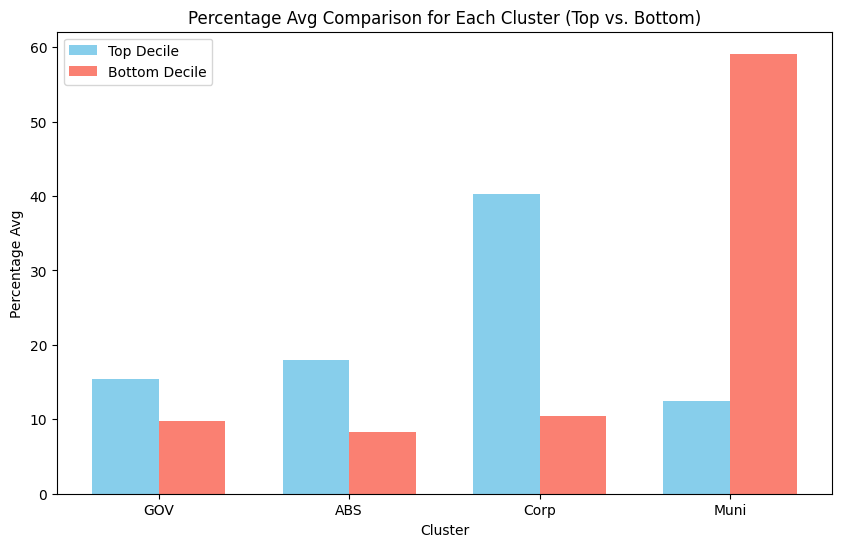

In [10]:
#6 ---- ### percentage comparision top vs. bottom for each cluster 
df_monthly_return, df_out = decile_plot(df=df, pred_weight=True, plot=False)
plot_concentration_avg(df_out, clusters=[group_0, group_1, group_2, group_3])

In [11]:
#6 ---- ### overall concentration of each cluster, top & bottom 
#df_monthly_return, df_out = decile_plot(df=df, pred_weight=True, plot=False)
#plot_decile_concentration_barchart(df_out, clusters=[group_0, group_1, group_2, group_3], deciles = [0,9])